In [53]:
import pandas as pd
import re
from Bio import SeqIO, AlignIO, Seq
import numpy as np
from collections import Counter
from helper import *
import python_cipres.client as CipresClient

### Extract fasta sequences for the autotrophic rubiscos
Before running this code we need to generate a file called `autotrophic_rubisco_70p.csv` by selecting in ITOL clades that belong to Rubisco types 1,2,2/3,3a,3c,3-like,3b and IV. We replaced sapces in the sequence ID to `_` to match the sequence ID in the fasta files. We take only sequences which are not type IV or type III-b as autotrophic.

In [4]:
uclust_data = pd.read_csv('../output/01_70p_tree/uclust_all_0.7.csv')
uclust_data = uclust_data[uclust_data['Type'] !='S']
uclust_data.loc[uclust_data['Target'] == '*','Target'] = uclust_data.loc[uclust_data['Target'] == '*','Query']
uclust_data['cut Target'] = uclust_data.Target.apply(lambda x: x.split(' ')[0])
#auto_id = [x.replace('\n','') for x in open('../output/01_70p_tree/autotrophic_rubisco_70p.txt').readlines() if x != '\n']
rubisco_types = pd.read_csv('../output/01_70p_tree/rubisco_types_70p.csv')
autotrophic_70p = rubisco_types[~rubisco_types['type'].isin(['IV','IIIb'])]
auto_rubisco = uclust_data.merge(autotrophic_70p, left_on='cut Target', right_on='ID')
autotrophic_rubisco  = auto_rubisco['Query'].values

auto_seq = []
for record in SeqIO.parse('../output/00_100p_tree/uclust_all_1.faa', "fasta"):
    if record.description in autotrophic_rubisco:
        auto_seq.append(record)
!mkdir -p ../output/02_80p_autotrophic_rubisco_tree
with open(r"../output/02_80p_autotrophic_rubisco_tree/autotrophic_rubisco_seq.faa", "w") as output_handle:
    SeqIO.write(auto_seq, output_handle, "fasta")

In [5]:
auto_rubisco.to_csv('../output/02_80p_autotrophic_rubisco_tree/uclust_all_0.7_with_type.csv')
auto_rubisco.groupby('type')['Query'].nunique()

type
I           36258
II            326
II/III         51
III-like       99
IIIa           95
IIIc           35
unknown        23
Name: Query, dtype: int64

### Cluster sequences using uclust

In [6]:
!../bin/usearch11.0.667_i86linux32 -cluster_fast ../output/02_80p_autotrophic_rubisco_tree/autotrophic_rubisco_seq.faa -id 0.8 -uc ../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.uc

usearch v11.0.667_i86linux32, 4.0Gb RAM (16.3Gb total), 8 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: yinonmoise.baron@weizmann.ac.il

00:00 64Mb    100.0% Reading ../output/02_80p_autotrophic_rubisco_tree/autotrophic_rubisco_seq.faa
00:00 102Mb   100.0% DF
00:00 102Mb  36887 seqs, 36887 uniques, 36887 singletons (100.0%)
00:00 102Mb  Min size 1, median 1, max 1, avg 1.00
00:00 108Mb   100.0% DB
00:02 163Mb   100.0% 325 clusters, max size 7716, avg 113.5
                                                           
      Seqs  36887 (36.9k)
  Clusters  325
  Max size  7716
  Avg size  113.5
  Min size  1
Singletons  169, 0.5% of seqs, 52.0% of clusters
   Max mem  163Mb
      Time  2.00s
Throughput  18.4k seqs/sec.



### Take only cluster fasta files and create csv file

In [7]:
parse_uclust(infile='../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.uc',
             fasta='../output/02_80p_autotrophic_rubisco_tree/autotrophic_rubisco_seq.faa',
             outfasta='../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.faa',
             outfile='../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.csv'
            )

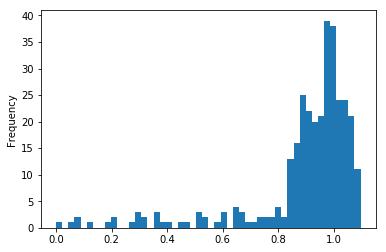

In [32]:
from Bio.Blast.Applications import NcbiblastpCommandline
#aln = AlignIO.read('../output/02_90p_autotrophic_rubisco_tree/auto_uclust_all_0.9_trimmed.aln',format='fasta')
output = NcbiblastpCommandline(query="../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.faa", subject="../data/Rr.faa", outfmt=5)()[0]
from Bio.Blast import NCBIXML
from io import StringIO

res = []
for x in NCBIXML.parse(StringIO(output)):
    if len(x.alignments) == 0:
        res.append(0)
    else:
        alignment = x.alignments[0]
        res.append(pd.DataFrame([[x.align_length,x.expect] for x in alignment.hsps]).sort_values(by=1).loc[0,0]/x.query_length)

seq = [x for x in SeqIO.parse('../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.faa',format='fasta')]

res_df = pd.Series(res,index=[x.id for x in seq])
%matplotlib inline
res_df.plot.hist(bins=50)


In [33]:
seqs = [x for x in seq if x.id in res_df[res_df >= 0.5].index]

with open(r"../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8_no_outliers.faa", "w") as output_handle:
    SeqIO.write(seqs, output_handle, "fasta")

In [8]:
auto_rub_80p = pd.read_csv('../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.csv')
auto_rub_80p = auto_rub_80p[auto_rub_80p['Type'] !='S']
auto_rub_80p.loc[auto_rub_80p['Target'] == '*','Target'] = auto_rub_80p.loc[auto_rub_80p['Target'] == '*','Query']

auto_rub80 = auto_rubisco.merge(auto_rub_80p,left_on='Query',right_on='Query')
auto_rub80.to_csv('../output/02_80p_autotrophic_rubisco_tree/uclust_all_0.8_with_type.csv')
auto_rub80.groupby('type')['Target_y'].nunique()

type
I           149
II           24
II/III       16
III-like     38
IIIa         53
IIIc         25
unknown      20
Name: Target_y, dtype: int64

## Create multiple sequence alignment

In [34]:
#!../bin/mafft-linux64/mafft.bat ../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.faa > ../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.aln
!../bin/mafft-linux64/mafft.bat ../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8_no_outliers.faa > ../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.aln

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
  301 / 304
done.

Constructing a UPGMA tree (efffree=0) ... 
  300 / 304
done.

Progressive alignment 1/2... 
STEP   207 / 303 
Reallocating..done. *alloclen = 2471
STEP   299 / 303  h
Reallocating..done. *alloclen = 3525
STEP   303 / 303  h
done.

Making a distance matrix from msa.. 
  300 / 304
done.

Constructing a UPGMA tree (efffree=1) ... 
  300 / 304
done.

Progressive alignment 2/2... 
STEP   218 / 303 
Reallocating..done. *alloclen = 2394
STEP   299 / 303  h
Reallocating..done. *alloclen = 3469
STEP   303 / 303  h
done.

disttbfast (aa) Version 7.427
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'maf

## Clean MSA to contain only positions with more than 5% coverage (based on Jaffe et al. 2018)

In [35]:
clean_aln(infile='../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.aln',
          outfile='../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8_trimmed.aln')

In [36]:
cip = CipresClient.Client(appname='RO',
                    appID='rubisco_phylogeny-49F87B124F3D429FBE12F95E4254DDEA',
                    baseUrl='https://cipresrest.sdsc.edu/cipresrest/v1',
                    username='yinonbaron',
                    password='Mchcav11~')


In [46]:
job = cip.submitJob(vParams={'toolId': 'RAXMLHPC8_REST_XSEDE',
                       'datatype_': 'protein',
                       'runtime_': '160',
                       'select_analysis_': 'fa',
                       'choose_bootstrap_': 'x',
                       'printbrlength_': '1'},
              inputParams={'infile_': '../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8_trimmed.aln'},
              metadata={'statusEmail':'true'})

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:794: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.org/en/latest/security.html
  InsecureRequestWarning)


In [356]:
job = cip.listJobs()[-1]

In [357]:
if cip.getJobStatus(jobHandle=job.jobHandle).isDone():
    !mkdir -p ../output/02_80p_autotrophic_rubisco_tree/RaxML/
    job.downloadResults('../output/02_80p_autotrophic_rubisco_tree/RaxML/')
else:
    print('Job ' + job.jobHandle + ' not finished')

In [40]:
uclust1 = pd.read_csv('../output/00_100p_tree/uclust_all_1.csv')
uclust_data = pd.read_csv('../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.csv')
uclust_data = uclust_data[uclust_data['Type'] !='S']
uclust_data.loc[uclust_data['Target'] == '*','Target'] = uclust_data.loc[uclust_data['Target'] == '*','Query']
uclust_data = uclust1.merge(uclust_data,left_on='Target',right_on='Query',suffixes=('_100', ''))
uclust_data.rename(columns={'Query':'Query_80','Query_100':'Query'},inplace=True)

In [41]:
add_type(type_file='../data/jaffe_et_al_2018_rubisco_types.csv',
         seq_file=uclust_data,
         outfile='../output/02_80p_autotrophic_rubisco_tree/type_legend.txt')

In [42]:
add_kinetic(kinetic_file='../data/flamholz_et_al_2019_kinetically_characterized.faa',
            synth_file='../data/milo_synthetized_rubisco.faa',
            seq_file='../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.csv',
            outfile='../output/02_80p_autotrophic_rubisco_tree/kinetic_legend.txt')

In [29]:
uclust_data = pd.read_csv('../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.csv')
uclust_data.loc[uclust_data['Target'] == '*','Target'] = uclust_data.loc[uclust_data['Target'] == '*','Query']
uclust_data.Target.nunique()


325

In [16]:
add_type(type_file='../data/jaffe_et_al_2018_rubisco_types.csv',
         seq_file='../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.csv',
         outfile='../output/02_80p_autotrophic_rubisco_tree/type_legend.txt')

In [17]:
add_kinetic(kinetic_file='../data/flamholz_et_al_2019_kinetically_characterized.faa',
            synth_file='../data/milo_synthetized_rubisco.faa',
            seq_file='../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.csv',
            outfile='../output/02_80p_autotrophic_rubisco_tree/kinetic_legend.txt')

In [18]:
type(uclust_data)

pandas.core.frame.DataFrame

In [5]:
type_file='../output/01_70p_tree/rubisco_types_70p.csv'
seq_file='../output/02_80p_autotrophic_rubisco_tree/auto_uclust_all_0.8.csv'
outfile='../output/02_80p_autotrophic_rubisco_tree/type_legend.txt'

labels = pd.read_csv(type_file)
uclust_data = pd.read_csv(seq_file)
uclust_data = uclust_data[uclust_data['Type'] !='S']
uclust_data.loc[uclust_data['Target'] == '*','Target'] = uclust_data.loc[uclust_data['Target'] == '*','Query']
uclust_data['cut Query'] = uclust_data.Query.apply(lambda x: x.split(' ')[0])
uclust_data = uclust_data.merge(labels, left_on='cut Query', right_on='ID',how='left')
labeled_leaves = uclust_data[~pd.isna(uclust_data['type'])]
color_map = {'I': '#28B463',
             'II': '#E74C3C',
             'II/III':'#AF7AC5',
             'IIIa':'#AED6F1',
             'IIIb':'#3498DB',
             'IIIc':'#1F618D',
             'IIIlike':'#5D6D7E',
             'IV':'#F4D03F',
             'IVlike':'#F8C471',
             'unknown':'#F442D4'}
lines = labeled_leaves['Target'].apply(lambda x: x.split(' ')[0]).values +[',label,node,'+color_map[x]+',1,normal\n' for x in labeled_leaves['type'].values]
lines = set(lines)
'''
with open('../data/itol_legend_template.txt','r') as file:
    with open(outfile, "w") as f1:
        for row in file:
            f1.write(row)
        for line in lines:
            f1.write(line)
        file.close()
        f1.close()
        '''

KeyError: 'III-like'